In [1]:
import tensorflow as tf

import numpy as np

import pandas as pd

import mne

import os

import keras

import seaborn as sns

from collections import Counter

from tqdm import tqdm_notebook
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

Using TensorFlow backend.


Какие каналы содержат 

Dataset:
- Один сэмпл содержит чанк сигнала, чанки не пересекаются
- Считывание происходит из случайных файлов из списка
- Чанки рандомизированы:
    - Учесть рандомизацию по номеру пациента, сессии, времени

# Read labels

In [2]:
header = ["file", "start", "end", "label", "confidence"]
train_df = pd.read_csv("../_DOCS/ref_train.txt", sep=" ", names=header)
val_df = pd.read_csv("../_DOCS/ref_dev.txt", sep=" ", names=header)

In [3]:
def preprocess_file(full_file):
    parts = full_file.split("_")
    patient = int(parts[0])
    session = int(parts[1][1:])
    file = int(parts[2][1:])
    return [patient, session, file]

In [4]:
preprocess_file("00000258_s002_t000")

[258, 2, 0]

In [5]:
def append_file_info(df):
    values = np.array(df["file"].apply(preprocess_file).tolist())
    files_df = pd.DataFrame(values, columns=["patient", "session", "chunk"], index=df.index)
    return df.merge(files_df, how="inner", left_index=True, right_index=True)

In [6]:
train_df = append_file_info(train_df)

In [7]:
val_df = append_file_info(val_df)

# Attach files

TODO add other electrode formats

In [8]:
def attach_files(df, dataset):
    paths = {}

    for root, dirs, files in os.walk("../edf/{}".format(dataset)):
        path = root.split(os.sep)
        for file in files:
            if ".edf" in file:
                name = file.split(".")[0]
                paths[name] = os.path.abspath(root) + "/" +  file
    
    df["full_path"] = df["file"].apply(paths.get)
    df = df[df["full_path"].apply(lambda x: "01_tcp_ar" in str(x))].copy()
    return df

In [9]:
train_df = attach_files(train_df, "train")

In [10]:
val_df = attach_files(val_df, "dev")

# Separate patients

In [11]:
# train_patients = train_df["patient"].unique() 

In [12]:
# val_patients = val_df["patient"].unique()

In [13]:
# val_df = val_df[~val_df["patient"].isin(train_patients)].copy()

# Remove bckg files

In [14]:
def remove_bckg_files(df):
    files_with_seizures = df[df["label"] == "seiz"]["file"].unique()
    return df[df["file"].isin(files_with_seizures)].copy()

In [15]:
train_df = remove_bckg_files(train_df)

In [16]:
val_df = remove_bckg_files(val_df)

# Calculate channels intersection and proper sample rate

In [17]:
def get_edf_info(df):
    files = df["full_path"].unique()

    edf_data = []

    for file in tqdm_notebook(files):
        edf = mne.io.read_raw_edf(file, verbose="ERROR", preload=True)
        edf_length = edf[:][1].shape[0]
        data = {
            field: edf.info[field]
            for field in ["ch_names", "sfreq"]
        }
        data["length"] = edf_length
        edf_data.append(data)
        
    df = pd.DataFrame(edf_data)
    df["full_path"] = files
    return df

In [18]:
train_edf_df = get_edf_info(train_df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [19]:
val_edf_df = get_edf_info(val_df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [20]:
MAX_LENGTH = int(min(train_edf_df["length"].quantile(0.1), val_edf_df["length"].quantile(0.1)))

In [21]:
train_df = train_df.merge(train_edf_df[["full_path", "length"]], on="full_path", how="left")
val_df = val_df.merge(val_edf_df[["full_path", "length"]], on="full_path", how="left")

In [22]:
train_df["length_chunks"] = train_df["length"] // MAX_LENGTH
val_df["length_chunks"] = val_df["length"] // MAX_LENGTH

In [29]:
MAX_LENGTH

66033

In [23]:
CHUNK_FREQUENCY = int(min(train_edf_df["sfreq"].min(), val_edf_df["sfreq"].min()))

In [24]:
counter = Counter([
    channel for channels_list in train_edf_df["ch_names"] for channel in channels_list
] + [
    channel for channels_list in val_edf_df["ch_names"] for channel in channels_list
])

In [25]:
all_channels = dict(counter.most_common())

In [26]:
usage_limit = max([v for k, v in all_channels.items() if "STI" not in k])
CHANNELS = [k for k, v in all_channels.items() if v >= usage_limit and "STI" not in k]

In [27]:
# STIM_CHANNEL = [k for k in all_channels.keys() if "STI" in k][0]

In [28]:
CHANNELS

['EEG P3-REF',
 'EEG FP2-REF',
 'EEG T5-REF',
 'EEG O1-REF',
 'EEG T4-REF',
 'EEG FP1-REF',
 'EEG F7-REF',
 'EEG F3-REF',
 'EEG CZ-REF',
 'EEG T6-REF',
 'EEG F4-REF',
 'EEG PZ-REF',
 'EEG A1-REF',
 'EEG A2-REF',
 'EEG F8-REF',
 'EEG P4-REF',
 'EEG C4-REF',
 'EEG FZ-REF',
 'EEG C3-REF',
 'EEG T3-REF',
 'EEG O2-REF']

In [37]:
len(CHANNELS)

21

In [38]:
CHANNELS_MAPPING = [
    ("EEG FP1-REF", "EEG F7-REF"), 
    ("EEG F7-REF", "EEG T3-REF"), 
    ("EEG T3-REF", "EEG T5-REF"), 
    ("EEG T5-REF", "EEG O1-REF"), 
    ("EEG FP2-REF", "EEG F8-REF"), 
    ("EEG F8-REF", "EEG T4-REF"), 
    ("EEG T4-REF", "EEG T6-REF"), 
    ("EEG T6-REF", "EEG O2-REF"), 
    ("EEG A1-REF", "EEG T3-REF"), 
    ("EEG T3-REF", "EEG C3-REF"), 
    ("EEG C3-REF", "EEG CZ-REF"), 
    ("EEG CZ-REF", "EEG C4-REF"), 
    ("EEG C4-REF", "EEG T4-REF"), 
    ("EEG T4-REF", "EEG A2-REF"), 
    ("EEG FP1-REF", "EEG F3-REF"), 
    ("EEG F3-REF", "EEG C3-REF"), 
    ("EEG C3-REF", "EEG P3-REF"), 
    ("EEG P3-REF", "EEG O1-REF"), 
    ("EEG FP2-REF", "EEG F4-REF"), 
    ("EEG F4-REF", "EEG C4-REF"), 
    ("EEG C4-REF", "EEG P4-REF"), 
    ("EEG P4-REF", "EEG O2-REF")
]

CHANNELS_MAPPING = [c for c in CHANNELS_MAPPING if (c[0] in CHANNELS) and (c[1] in CHANNELS)]

CHANNELS_MAPPING_1 = [c[0] for c in CHANNELS_MAPPING]
CHANNELS_MAPPING_2 = [c[1] for c in CHANNELS_MAPPING]

# Calculate chunk size

In [39]:
train_df["duration"] = train_df["end"] - train_df["start"]

label
bckg    AxesSubplot(0.125,0.125;0.775x0.755)
seiz    AxesSubplot(0.125,0.125;0.775x0.755)
Name: duration, dtype: object

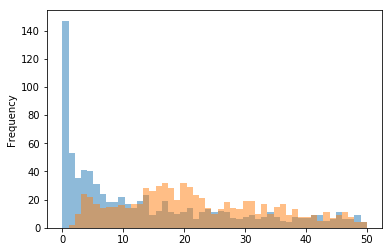

In [40]:
train_df.groupby('label')["duration"].plot(kind="hist", bins=np.linspace(0, 50), alpha=0.5)

In [41]:
CHUNK_TIME = 1 * CHUNK_FREQUENCY # number of terms per chunk

# Split on chunks

- Get all file names, randomize them
- For each file - split on chunks, randomize them
- Get labels for each chunk

In [42]:
BATCH_SIZE = 128

In [43]:
FFT_STEPS_NUM = 125

TODO:
- Fourier transform for chunk instead of full file

Как западить чанку нулями, и убрать их из лосса? Варианты:

### Удалять пустые чанки
3. Заменить в массиве data и events неполные чанки на зануленные
4. Добавить параметр mask, который отвечает за то, какие элементы функции потерь оставить
5. Заменить лосс


In [44]:
! mkdir ../processed-data

In [45]:
train_df.to_csv("../processed-data/train.csv", index=False)
val_df.to_csv("../processed-data/val.csv", index=False)

In [46]:
from scipy.signal import stft

In [47]:
# def get_fourier_transform(data, window_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM):
#     frequencies = []
#     for window in range(0, data.shape[0] - window_size, step_size):
#         chunk = data[window:window + window_size]
#         frequency_values = np.abs(np.fft.fft(chunk, axis=0))[:window_size // 2]
#         frequencies.append(frequency_values)
#     result = np.stack(frequencies)
#     return result

In [48]:
import numpy as np

In [49]:
def get_fourier_transform(data, window_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM, SCALING_FACTOR=100):
    data = data.T
    return np.log1p(np.abs(stft(
        data, 
        fs=window_size, 
        window="hann", 
        nperseg=window_size, 
        noverlap=window_size - step_size, 
        return_onesided=True, 
        boundary=None,
    )[-1]).T)

In [50]:
def get_data(df, file, chunk, channels=CHANNELS, chunk_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM):
    annotations = df[
        (df["full_path"] == file) & \
        (df["label"] == "seiz")
    ][["start", "end"]]
    edf = mne.io.read_raw_edf(file, preload=True, verbose='ERROR')
    edf.filter(2, 60)
    edf_picks = edf.pick_channels(channels)
    data, time = edf_picks[:, chunk * MAX_LENGTH:(chunk + 1) * MAX_LENGTH]
    
    events = time * 0
    for _, (start, end) in annotations.iterrows():
        events += (time >= start) & (time <= end)
    events = (events > 0).astype(int)
    
    del edf
    
    return data, events

In [51]:
def get_data_multiple(df, files, channels=CHANNELS, chunk_size=CHUNK_TIME):
    total_data = []
    total_events = []
    for file, chunk in tqdm_notebook(files):
        data, events = get_data(df, file, chunk)
        total_data.append(data)
        total_events.append(events)
    
    return total_data, total_events

In [52]:
class ChunksIterator():
    def __init__(self, data, events, chunk_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM, max_length=MAX_LENGTH, tqdm_enabled=False):
        self.data = data
        self.events = events
        self.chunk_size = chunk_size
        self.step_size = step_size
        self.valid_chunks = 0
        
        max_time = min(max([e.shape[0] for e in events]), max_length)
        self.iterations = range(0, max_time - 2*chunk_size, chunk_size)
        self.iterations = np.random.choice(self.iterations, len(self.iterations), replace=False)
        self.iterations_number = len(self.iterations)
        if tqdm_enabled:
            self.iterations = tqdm(self.iterations)
        self.iterations = iter(self.iterations)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        data = self.data
        events = self.events
        chunk_size = self.chunk_size
        step_size = self.step_size
        chunk_start = next(self.iterations)
        
        data_chunk = [d[:, chunk_start:chunk_start + 2*chunk_size].T for d in data]
        labels_chunk = [e[chunk_start:chunk_start + chunk_size] for e in events]

        zero_data_chunk = np.zeros((chunk_size * 2, len(CHANNELS)))
        zero_labels_chunk = np.zeros((chunk_size, ))

        masks_chunk = [e.shape[0] == chunk_size for e in labels_chunk]
        data_chunk = [d if d.shape[0] == 2*chunk_size else zero_data_chunk for d in data_chunk]
        labels_chunk = [e if e.shape[0] == chunk_size else zero_labels_chunk for e in labels_chunk]

        data_chunk = [get_fourier_transform(d) for d in data_chunk]
        labels_chunk = [e.max() for e in labels_chunk]
        
        self.valid_chunks += sum(masks_chunk)

        return np.stack(data_chunk).reshape(len(data_chunk), -1), np.stack(labels_chunk)[:, np.newaxis], np.array(masks_chunk)

In [53]:
def iterate_files(df, batch_size=BATCH_SIZE):
    files = df[["full_path", "length_chunks"]].drop_duplicates().values
    file_chunks = []
    for file, chunks in files:
        for chunk in range(chunks + 1):
            file_chunks.append((file, chunk))
    files_number_to_add = (batch_size - len(file_chunks) % batch_size)
    files_to_add = file_chunks[0:files_number_to_add]
    file_chunks = file_chunks + files_to_add
    
    file_chunks_index = list(range(len(file_chunks)))
    file_chunks_index = np.random.choice(file_chunks_index, len(file_chunks_index), replace=False)
    file_chunks = [file_chunks[i] for i in file_chunks_index]
    for files in zip(*[iter(file_chunks)]*batch_size):
        yield files

In [54]:
files = next(iterate_files(train_df))

In [55]:
data, events = get_data(train_df, files[0][0], files[0][1])

In [56]:
data.shape

(21, 66033)

In [57]:
data, events = get_data_multiple(train_df, files)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [58]:
partial_lengths = [int(d.shape[1] * 0.5) for d in data]
partial_data = [d[:, :l] for d, l in zip(data, partial_lengths)]
partial_events = [e[:l] for e, l in zip(events, partial_lengths)]
min(partial_lengths)

158

In [59]:
iterator = ChunksIterator(partial_data, partial_events, tqdm_enabled=True)

print("Total iterations:", iterator.iterations_number)

for i, (data_chunk, labels_chunk, masks_chunk) in zip(range(10), iterator):
    print("Iteration {}".format(i), sum(masks_chunk))
    
print("Valid chunks:", iterator.valid_chunks)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Total iterations: 131
Iteration 0 126
Iteration 1 127
Iteration 2 104
Iteration 3 113
Iteration 4 122
Iteration 5 125
Iteration 6 110
Iteration 7 107
Iteration 8 106
Iteration 9 116
Valid chunks: 1156


In [60]:
data_chunk.shape

(128, 333396)

# Model creation

In [61]:
NUM_EPOCHS = 10

In [62]:
import tensorflow as tf
from keras.layers import Dense,Activation,Dropout, Input, Conv1D, MaxPool1D, Flatten
from keras.layers import LSTM,Bidirectional,TimeDistributed #could try TimeDistributed(Dense(...))
from keras.models import Sequential, load_model
from keras import optimizers,regularizers
from keras.layers.normalization import BatchNormalization
import keras.backend.tensorflow_backend as KTF

In [63]:
eeg_input = Input(shape=((FFT_STEPS_NUM + 1) * (CHUNK_TIME // 2 + 1) * len(CHANNELS), ))

x = eeg_input
x = Dropout(0.2)(x)

for _ in range(3):
    x = Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
events_output = Dense(1, activation='sigmoid')(x)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [64]:
model = keras.models.Model(inputs=[eeg_input], outputs=[events_output])

In [65]:
s = tf.Session()

In [66]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [67]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam', 
    metrics=['accuracy', recall_m, precision_m]
)

# TODO Try to filter incomplete chunks

# Overfit on small dataset

TODO make model converge on this batch

In [68]:
generator = ChunksIterator(data, events)

In [69]:
for i in range(5):
    next(generator)
x_in, y_end, masks_in = next(generator)

In [70]:
y_end.sum() / (y_end > -1).sum()

0.2421875

In [71]:
model.predict(x_in).mean()

0.5000012

In [72]:
model.evaluate(x_in, y_end)

128/128 [==============================] - 1s 6ms/step


[5.797127723693848, 0.3515625, 0.96875, 0.26678525656461716]

In [73]:
# model.fit(x_in, y_end, batch_size=x_in.shape[0], epochs=1000, sample_weight=masks_in)

In [74]:
y_end.sum()

31.0

RNN использовать можно и даже немного нужно
А вот seq2seq не надо - у вас же одинаковая длина входа и выхода. Имплементация будет очень похожа не языковую модельку, как была в последней домашке.

Если это исследования, а не в прод катить, я бы попробовал LMU и LSTM-SHA из реккурентных и Sparse Transformer

# Train model

In [75]:
GENERATOR_PAD_BUG = 1

В iterate files добавить конкретную чанку, по которой будет осуществляться итерация. Т.е. :
- Сохранять длину файла
- Разделить каждый файл на чанки длины MAXLEN
- 

In [76]:
total_train_history = {}
total_val_history = {}

In [78]:
for epoch in tqdm(range(3, 10)):
    total_train_history[epoch] = []
    total_val_history[epoch] = []
    
    total_train_loss = 0
    total_train_chunks = 0
    
    total_val_loss = 0
    total_val_chunks = 0
    
    
    for train_files in tqdm_notebook(list(iterate_files(train_df))):
        # Training
        
        train_data, train_events = get_data_multiple(train_df, train_files)
        train_generator = ChunksIterator(train_data, train_events, tqdm_enabled=True)
        
        train_chunks = train_generator.iterations_number
        
        train_history = model.fit_generator(
            train_generator, 
            epochs=1, 
            steps_per_epoch=train_chunks - GENERATOR_PAD_BUG,
#             class_weight=[1, 10]
#             pickle_safe=False
        )
        
        total_train_loss += train_history.history['loss'][0] * train_generator.valid_chunks
        total_train_chunks += train_generator.valid_chunks
        
        model.reset_states()
        
        del train_generator
        del train_data
        del train_events
        
        total_train_history[epoch].append(total_train_loss / total_train_chunks)
        print("Train loss:", total_train_history)
        
        model.save_weights("./models/big-fc-fft-model-{}.h5".format(epoch))
        
    for val_files in tqdm_notebook(list(iterate_files(val_df))):
        # Validation
        
        val_data, val_events = get_data_multiple(val_df, val_files)
        val_generator = ChunksIterator(val_data, val_events, tqdm_enabled=True)
        
        val_chunks = val_generator.iterations_number
        
        val_metrics = model.evaluate_generator(
            val_generator,
            steps=val_chunks - GENERATOR_PAD_BUG
#             pickle_safe=False
        )
        
        print(val_metrics)
        
        total_val_loss += val_metrics[0] * val_generator.valid_chunks
        total_val_chunks += val_generator.valid_chunks
        
        model.reset_states()
        del val_generator
        del val_data
        del val_events
        
        total_val_history[epoch].append(total_val_loss / total_val_chunks)
        print("Val loss:", total_val_history)
    

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
213/262 [=======================>......] - ETA: 1:54 - loss: 1.5107 - acc: 0.8480 - recall_m: 0.5351 - precision_m: 0.7582



KeyboardInterrupt: 

In [ ]:
model.save_weights("./models/big-fc-fft-model-test.h5")

In [66]:
# model.load_weights("./models/fc-fft-model-test.h5")

In [71]:
total_train_history

{0: [0.5527868072950203,
  0.5601780045079747,
  0.5959786756940421,
  0.5962760830803113,
  0.6083952422474316,
  0.5960560154136758,
  0.5829306107755939,
  0.5825752300448727,
  0.5826259460580903,
  0.5868508032463577,
  0.5876766684631173,
  0.5830250426195953,
  0.5695623656849442,
  0.5653754079029228,
  0.5589459717359553],
 1: [0.5566639469097588,
  0.5464663337205202,
  0.537863203107527,
  0.5317602389133965,
  0.5292729051409191,
  0.5304131717308752,
  0.5291984345770542,
  0.531866389907757,
  0.5336059717843278,
  0.5343092860576365,
  0.5362615392111674,
  0.5355638393551668,
  0.533698805882653,
  0.5339488142151946,
  0.5370076224068736],
 2: [0.4956817824876946,
  0.4826458186059948,
  0.5298329865685152,
  0.5232543032786595,
  0.5162434065269783,
  0.5094764626925673,
  0.5132683052025875,
  0.5064873864976246,
  0.5100268925878999,
  0.5094159528070755,
  0.5103880445000529,
  0.5134067597239748,
  0.5102687981882494,
  0.5102764647597885,
  0.5072682944069941],
 

In [72]:
total_val_history

{0: [1.1559233226393926,
  1.0663201794597703,
  0.9681971916236115,
  0.9625123893026386,
  0.9269609428792275,
  0.9219772925448473,
  0.9165221060593823,
  0.9261915431906044],
 1: [1.2925348661783087,
  1.3355964680461436,
  1.3565252965534185,
  1.3697498547559346,
  1.2965438038510957,
  1.295650376553495,
  1.2737540053348053,
  1.2586257783408543],
 2: [0.8445460609807313,
  0.8405446844369043,
  0.8396399402030775,
  0.8389156346480717,
  0.8371482909961124,
  0.8335879144450005,
  0.8247572308261922,
  0.8235682989625159],
 3: [0.7341108722541169]}

# Prediction

In [73]:
test_files = next(iterate_files(val_df))

In [74]:
test_data, test_events = get_data_multiple(val_df, test_files)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [75]:
class TestGenerator():
    def __init__(self, data, events):
        self.events = []
        self.generator = ChunksIterator(data, events, tqdm_enabled=False)
        self.generator.iterations = iter(tqdm(list(sorted(self.generator.iterations))))
    
    def __iter__(self):
        return self
    
    def __next__(self):
        data_chunk, events_chunk, masks_chunk = next(self.generator)
        self.events.append(events_chunk)
        return data_chunk, events_chunk

In [76]:
model.reset_states()

test_generator = TestGenerator(test_data, test_events)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [77]:
prediction = model.predict_generator(
    test_generator,
    test_generator.generator.iterations_number
)

In [78]:
all_true_events = np.stack(test_generator.events)

In [79]:
all_predicted_events = prediction.reshape(*all_true_events.shape)

In [80]:
(all_true_events > 0.5).sum() / (all_true_events > -1).sum()

0.19180727186311788

In [81]:
all_predicted_events[all_true_events > 0.5].mean()

0.2772244

In [82]:
all_predicted_events[all_true_events < 0.5].mean()

0.17840248

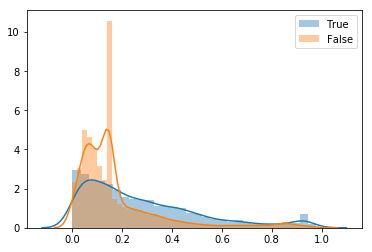

In [83]:
sns.distplot(all_predicted_events[all_true_events > 0.5], label="True")
sns.distplot(all_predicted_events[all_true_events < 0.5], label="False")
plt.legend()

In [84]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [85]:
min_seizure_duration = 10 * CHUNK_FREQUENCY

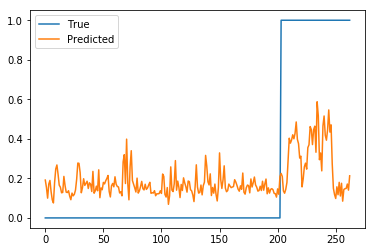

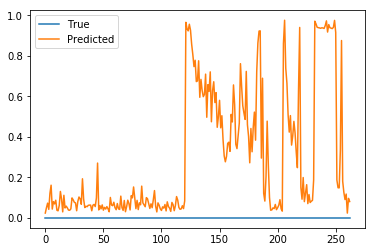

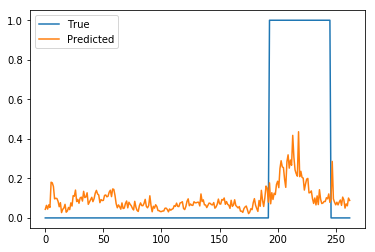

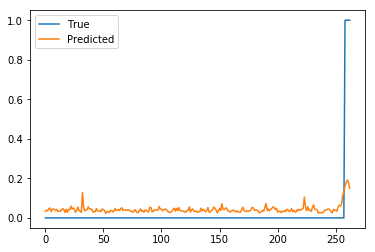

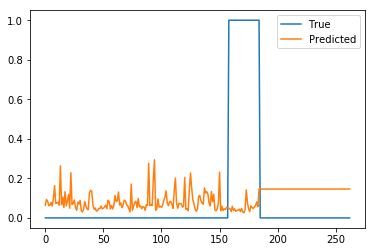

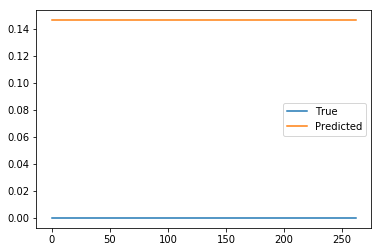

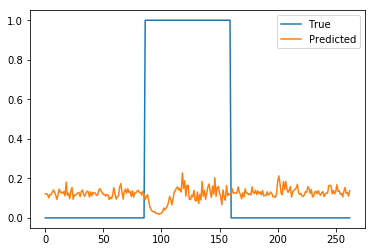

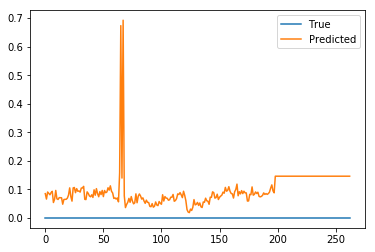

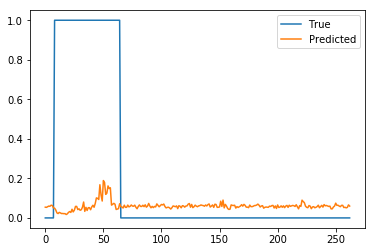

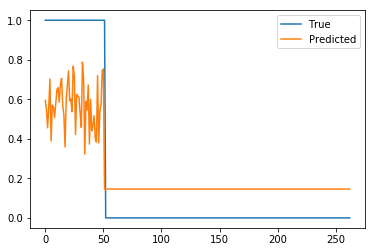

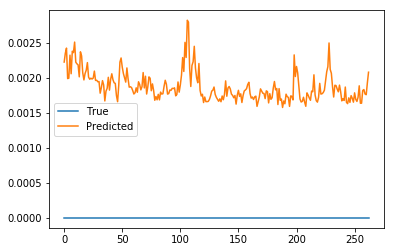

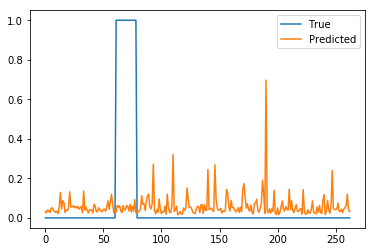

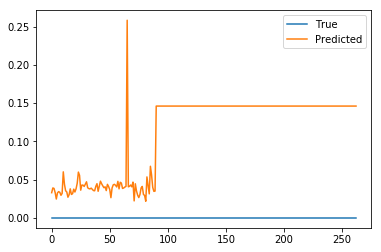

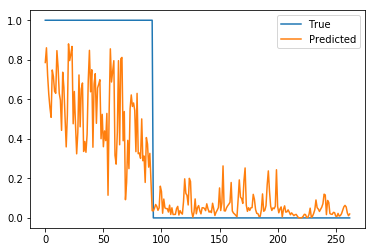

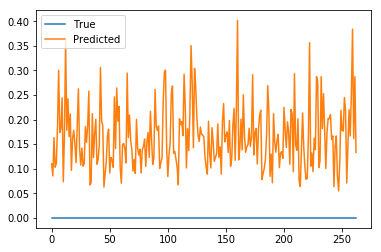

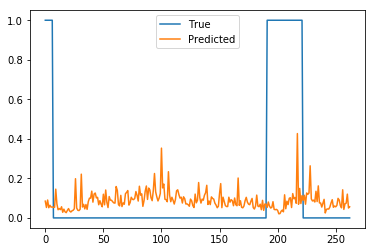

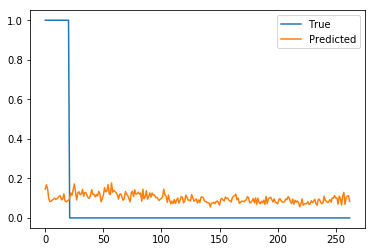

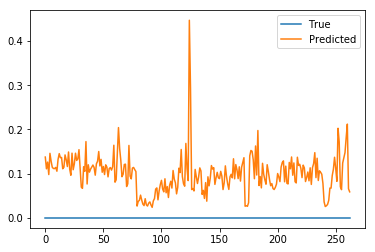

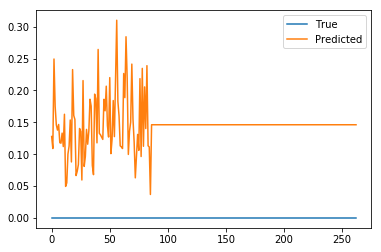

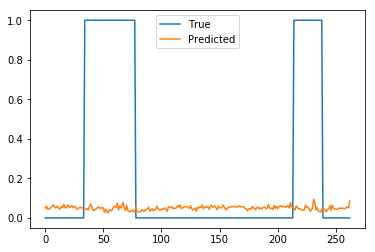

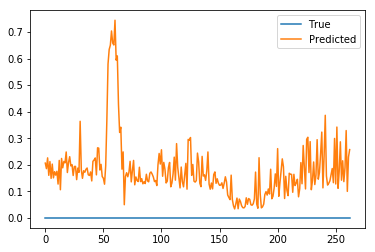

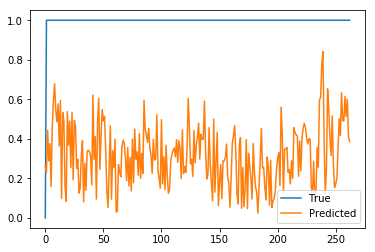

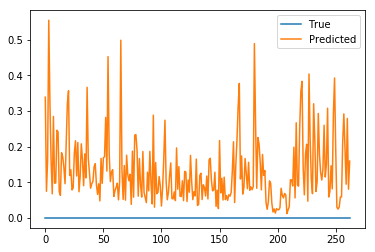

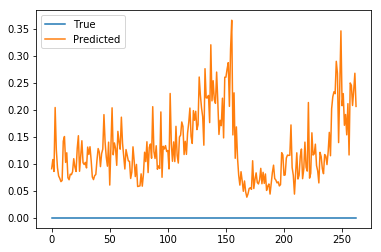

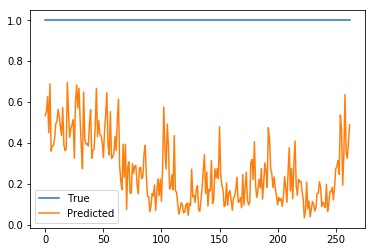

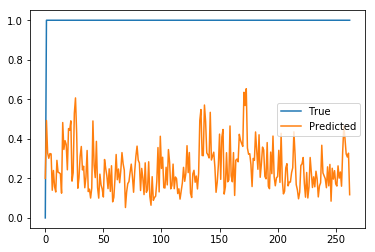

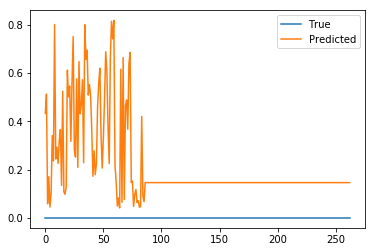

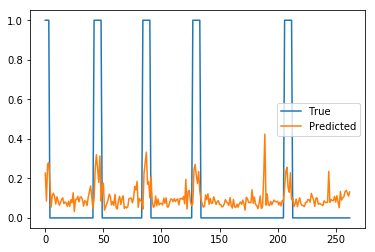

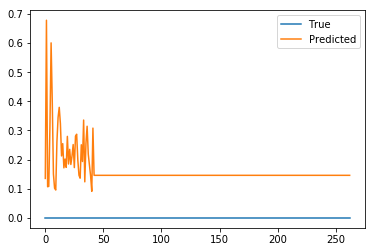

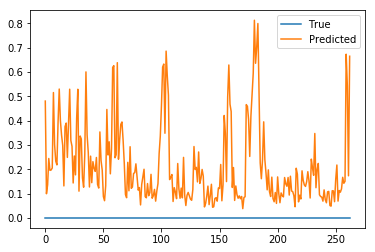

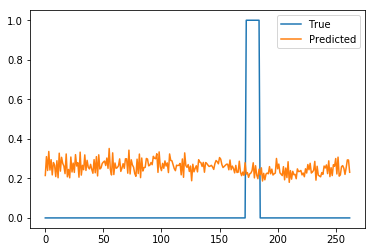

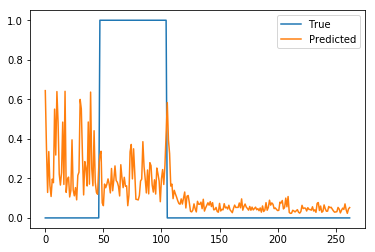

In [86]:
for series in range(32):
    true_events_line = all_true_events[:, series, :].reshape(-1)
    predicted_events_line = all_predicted_events[:, series, :].reshape(-1)
    smoothed_events_line = (moving_average(predicted_events_line, n=min_seizure_duration) > 0.3).astype(int)
    plt.plot(true_events_line, label="True")
    plt.plot(predicted_events_line, label="Predicted")
#     plt.plot(smoothed_events_line, label="Smoothed")
    plt.legend()
    plt.show()

# Heuristic smoothing

0. Merging events
1. Probabilistic filtering 
2. Duration filtering
3. Target aggregation

In [41]:
def merging_events(y_pred, threshold=0.5):
    events = []
    prev_class = "bckg"
    curr_class = None
    event_start = 0
        
    for index, value in enumerate(y_pred):
        if (value > 0.5):
            curr_class = "seiz"
        else:
            curr_class = "bckg"
            
        if prev_class != curr_class:
            event = {
                "start": event_start,
                "end": index,
                "class": prev_class,
                "probability": y_pred[event_start:index].mean()
            }
            prev_class = curr_class
            event_start = index
            events.append(event)
            
    event = {
        "start": event_start,
        "end": index,
        "class": prev_class,
        "probability": y_pred[event_start:index].mean()
    }
    events.append(event)
        
    return events

In [42]:
def probabilistic_filtering(events, threshold=0.75):
    new_events = []
    skip_next = False
    
    for index, event in enumerate(events):
        if skip_next:
            skip_next = False
            continue
        elif (event["class"] == "seiz") and (event["probability"] < threshold):
            previous_event = new_events[-1]
            next_event = events[index + 1]
            new_event = previous_event
            new_event["end"] = next_event["end"]
            new_event["probability"] = (next_event["probability"] + previous_event["probability"]) / 2
            skip_next = True
        else:
            new_events.append(event)
            
    return new_events

In [43]:
def duration_filtering(events, threshold=3):
    new_events = []
    skip_next = False
    
    for index, event in enumerate(events):
        if skip_next:
            skip_next = False
            continue
        elif (event["class"] == "seiz") and ((event["end"] - event["start"]) < threshold):
            previous_event = new_events[-1]
            next_event = events[index + 1]
            print(previous_event, next_event)
            new_event = previous_event
            new_event["end"] = next_event["end"]
            new_event["probability"] = (next_event["probability"] + previous_event["probability"]) / 2
            skip_next = True
        else:
            new_events.append(event)
    
    return new_events

In [56]:
def target_aggregation(events, margin=3.54):
    new_events = []
    skip_next = False
    
    for index, event in enumerate(events):
        if skip_next:
            skip_next = False
            continue
        elif (event["class"] == "bckg") and ((event["end"] - event["start"]) < margin) and (index > 0):
            previous_event = new_events[-1]
            next_event = events[index + 1]
            
            new_event = previous_event
            new_event["end"] = next_event["end"]
            new_event["probability"] = (next_event["probability"] + previous_event["probability"]) / 2
            skip_next = True
        else:
            new_events.append(event)
    
    return new_events

In [57]:
events = [{
    'class': 'bckg',
    'start': 0,
    'end': 2,
    'probability': 0.91
}, {
    'class': 'seiz',
    'start': 2,
    'end': 5,
    'probability': 0.97
}, {
    'class': 'bckg',
    'start': 5,
    'end': 10,
    'probability': 0.88
}, {
    'class': 'seiz',
    'start': 10,
    'end': 22,
    'probability': 0.77
}, {
    'class': 'bckg',
    'start': 22,
    'end': 24,
    'probability': 0.82
}, {
    'class': 'seiz',
    'start': 24,
    'end': 28,
    'probability': 0.87
}, {
    'class': 'bckg',
    'start': 28,
    'end': 32,
    'probability': 0.61
}, {
    'class': 'seiz',
    'start': 32,
    'end': 37,
    'probability': 0.57
}, {
    'class': 'bckg',
    'start': 37,
    'end': 42,
    'probability': 0.72
}, {
    'class': 'seiz',
    'start': 42,
    'end': 43,
    'probability': 0.9
}, {
    'class': 'bckg',
    'start': 43,
    'end': 45,
    'probability': 0.6
}]

for event in events:
    if event["class"] == "bckg":
        event["probability"] = 1 - event["probability"]

In [58]:
# events = merging_events(predicted_events_line)
events

[{'class': 'bckg', 'end': 2, 'probability': 0.08999999999999997, 'start': 0},
 {'class': 'seiz', 'end': 5, 'probability': 0.97, 'start': 2},
 {'class': 'bckg', 'end': 10, 'probability': 0.12, 'start': 5},
 {'class': 'seiz', 'end': 22, 'probability': 0.77, 'start': 10},
 {'class': 'bckg', 'end': 24, 'probability': 0.18000000000000005, 'start': 22},
 {'class': 'seiz', 'end': 28, 'probability': 0.87, 'start': 24},
 {'class': 'bckg', 'end': 32, 'probability': 0.39, 'start': 28},
 {'class': 'seiz', 'end': 37, 'probability': 0.57, 'start': 32},
 {'class': 'bckg', 'end': 42, 'probability': 0.28, 'start': 37},
 {'class': 'seiz', 'end': 43, 'probability': 0.9, 'start': 42},
 {'class': 'bckg', 'end': 45, 'probability': 0.4, 'start': 43}]

In [59]:
events = probabilistic_filtering(events)
events

[{'class': 'bckg', 'end': 2, 'probability': 0.08999999999999997, 'start': 0},
 {'class': 'seiz', 'end': 5, 'probability': 0.97, 'start': 2},
 {'class': 'bckg', 'end': 10, 'probability': 0.12, 'start': 5},
 {'class': 'seiz', 'end': 22, 'probability': 0.77, 'start': 10},
 {'class': 'bckg', 'end': 24, 'probability': 0.18000000000000005, 'start': 22},
 {'class': 'seiz', 'end': 28, 'probability': 0.87, 'start': 24},
 {'class': 'bckg', 'end': 42, 'probability': 0.335, 'start': 28},
 {'class': 'seiz', 'end': 43, 'probability': 0.9, 'start': 42},
 {'class': 'bckg', 'end': 45, 'probability': 0.4, 'start': 43}]

In [60]:
events = duration_filtering(events)
events

{'class': 'bckg', 'start': 28, 'probability': 0.335, 'end': 42} {'class': 'bckg', 'start': 43, 'probability': 0.4, 'end': 45}


[{'class': 'bckg', 'end': 2, 'probability': 0.08999999999999997, 'start': 0},
 {'class': 'seiz', 'end': 5, 'probability': 0.97, 'start': 2},
 {'class': 'bckg', 'end': 10, 'probability': 0.12, 'start': 5},
 {'class': 'seiz', 'end': 22, 'probability': 0.77, 'start': 10},
 {'class': 'bckg', 'end': 24, 'probability': 0.18000000000000005, 'start': 22},
 {'class': 'seiz', 'end': 28, 'probability': 0.87, 'start': 24},
 {'class': 'bckg', 'end': 45, 'probability': 0.36750000000000005, 'start': 28}]

In [61]:
events = target_aggregation(events)
events

[{'class': 'bckg', 'end': 2, 'probability': 0.08999999999999997, 'start': 0},
 {'class': 'seiz', 'end': 5, 'probability': 0.97, 'start': 2},
 {'class': 'bckg', 'end': 10, 'probability': 0.12, 'start': 5},
 {'class': 'seiz', 'end': 28, 'probability': 0.8200000000000001, 'start': 10},
 {'class': 'bckg', 'end': 45, 'probability': 0.36750000000000005, 'start': 28}]

# Running prediction for val dataset

- Increase batch size
- Preprocess chunks to frequencies
- 